In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

setup date from the past correlation analysis following the same steps of the previusly part

In [54]:
fatalities_df = pd.read_csv('fatalities_isr_pse_conflict_2000_to_2023.csv')

In [55]:
age_mean = fatalities_df['age'].mean()
fatalities_df['age'].fillna(age_mean, inplace=True)
gender_mode = fatalities_df['gender'].mode()[0]
fatalities_df['gender'].fillna(gender_mode, inplace=True)
place_of_residence_mode = fatalities_df['place_of_residence'].mode()[0]
fatalities_df['place_of_residence'].fillna(place_of_residence_mode, inplace=True)
place_of_residence_district_mode = fatalities_df['place_of_residence_district'].mode()[0]
fatalities_df['place_of_residence_district'].fillna(place_of_residence_district_mode, inplace=True)
type_of_injury_mode = fatalities_df['type_of_injury'].mode()[0]
fatalities_df['type_of_injury'].fillna(type_of_injury_mode, inplace=True)
notes_mode = fatalities_df['notes'].mode()[0]
fatalities_df['notes'].fillna(notes_mode, inplace=True)
fatalities_df.drop(['took_part_in_the_hostilities', 'ammunition'], axis=1, inplace=True)

In [56]:
fatalities_df.describe(include="all")

,name,date_of_event,age,citizenship,event_location,event_location_district,event_location_region,date_of_death,gender,place_of_residence,place_of_residence_district,type_of_injury,killed_by,notes
count,11124,11124,11124.000000,11124,11124,11124,11124,11124,11124,11124,11124,11124,11124,11124
unique,11083,2405,NaN,4,494,20,3,2593,2,580,20,13,3,6744
top,Name unknown to B'Tselem,2008-12-27,NaN,Palestinian,Gaza City,Gaza,Gaza Strip,2008-12-27,M,Gaza city,Gaza,gunfire,Israeli security forces,"Killed during ""Operation Defensive Shield."""
freq,23,357,NaN,10092,2232,2435,7733,341,9701,2351,2521,10140,10000,393
mean,NaN,NaN,26.745703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,13.700404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,19.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,23.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,31.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
import copy
data = copy.deepcopy(fatalities_df)

working on encoding variables for correlation

In [58]:
cat_cols = ['citizenship', 'event_location','event_location_district', 'event_location_region','gender', 
            'place_of_residence','place_of_residence_district', 'type_of_injury','killed_by']

for x in cat_cols:
    print("column",x,"has nulls:",data[x].hasnans,",count:",data[x].isnull().sum())
    data[x+"_cat"] = pd.CategoricalIndex(data[x]).codes

column citizenship has nulls: False ,count: 0
column event_location has nulls: False ,count: 0
column event_location_district has nulls: False ,count: 0
column event_location_region has nulls: False ,count: 0
column gender has nulls: False ,count: 0
column place_of_residence has nulls: False ,count: 0
column place_of_residence_district has nulls: False ,count: 0
column type_of_injury has nulls: False ,count: 0
column killed_by has nulls: False ,count: 0


In [59]:
data.columns

Index(['name', 'date_of_event', 'age', 'citizenship', 'event_location',
       'event_location_district', 'event_location_region', 'date_of_death',
       'gender', 'place_of_residence', 'place_of_residence_district',
       'type_of_injury', 'killed_by', 'notes', 'citizenship_cat',
       'event_location_cat', 'event_location_district_cat',
       'event_location_region_cat', 'gender_cat', 'place_of_residence_cat',
       'place_of_residence_district_cat', 'type_of_injury_cat',
       'killed_by_cat'],
      dtype='object')

In [60]:
data[['citizenship_cat',
       'event_location_cat', 'event_location_district_cat',
       'event_location_region_cat', 'gender_cat', 'place_of_residence_cat',
       'place_of_residence_district_cat', 'type_of_injury_cat',
       'killed_by_cat']].describe(include="all")

,citizenship_cat,event_location_cat,event_location_district_cat,event_location_region_cat,gender_cat,place_of_residence_cat,place_of_residence_district_cat,type_of_injury_cat,killed_by_cat
count,11124.000000,11124.000000,11124.000000,11124.000000,11124.000000,11124.000000,11124.000000,11124.000000,11124.000000
mean,2.814545,222.079468,8.341514,0.548634,0.872078,262.741999,7.630888,5.071647,1.083783
std,0.580204,121.403074,4.854510,0.857494,0.334018,150.537064,4.502653,1.052770,0.306646
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,155.000000,3.000000,0.000000,1.000000,178.000000,3.000000,5.000000,1.000000
50%,3.000000,194.000000,10.000000,0.000000,1.000000,225.000000,9.000000,5.000000,1.000000
75%,3.000000,321.000000,12.000000,1.000000,1.000000,397.000000,11.000000,5.000000,1.000000
max,3.000000,493.000000,19.000000,2.000000,1.000000,579.000000,19.000000,12.000000,2.000000


In [61]:
data[['citizenship_cat',
       'event_location_cat', 'event_location_district_cat',
       'event_location_region_cat', 'gender_cat', 'place_of_residence_cat',
       'place_of_residence_district_cat', 'type_of_injury_cat',
       'killed_by_cat']].corr()

,citizenship_cat,event_location_cat,event_location_district_cat,event_location_region_cat,gender_cat,place_of_residence_cat,place_of_residence_district_cat,type_of_injury_cat,killed_by_cat
citizenship_cat,1.000000,0.007435,0.031968,-0.206936,0.185143,0.023185,0.074902,0.240178,-0.951583
event_location_cat,0.007435,1.000000,0.080989,0.090513,0.016431,0.663725,0.079720,-0.040298,-0.007197
event_location_district_cat,0.031968,0.080989,1.000000,0.200915,0.025725,0.046407,0.825565,-0.096685,-0.040119
event_location_region_cat,-0.206936,0.090513,0.200915,1.000000,0.052327,0.071052,0.186646,-0.096329,0.153063
gender_cat,0.185143,0.016431,0.025725,0.052327,1.000000,0.025389,0.021924,0.085381,-0.182377
place_of_residence_cat,0.023185,0.663725,0.046407,0.071052,0.025389,1.000000,0.050790,-0.027422,-0.024482
place_of_residence_district_cat,0.074902,0.079720,0.825565,0.186646,0.021924,0.050790,1.000000,-0.053348,-0.081456
type_of_injury_cat,0.240178,-0.040298,-0.096685,-0.096329,0.085381,-0.027422,-0.053348,1.000000,-0.235260
killed_by_cat,-0.951583,-0.007197,-0.040119,0.153063,-0.182377,-0.024482,-0.081456,-0.235260,1.000000


## PCA Analysis

In [62]:
mydata = data[['citizenship_cat', 'event_location_cat',
    'event_location_district_cat', 'event_location_region_cat',
    'gender_cat', 'place_of_residence_cat',
    'place_of_residence_district_cat', 'type_of_injury_cat',
    'killed_by_cat']]

components_range = range(1,len(mydata.columns)+1)

for n in components_range:
    pca = PCA(n_components=n)
    pca.fit(mydata)
    print(n,"components, variance ratio=",pca.explained_variance_ratio_)

1 components, variance ratio= [0.84015491]
2 components, variance ratio= [0.84015491 0.15861851]
3 components, variance ratio= [0.84015491 0.15861851 0.00106262]
4 components, variance ratio= [8.40154912e-01 1.58618508e-01 1.06261982e-03 1.01767769e-04]
5 components, variance ratio= [8.40154912e-01 1.58618508e-01 1.06261982e-03 1.01767769e-04
 3.07056467e-05]
6 components, variance ratio= [8.40154912e-01 1.58618508e-01 1.06261982e-03 1.01767769e-04
 3.07056467e-05 1.89348345e-05]
7 components, variance ratio= [8.40154912e-01 1.58618508e-01 1.06261982e-03 1.01767769e-04
 3.07056467e-05 1.89348345e-05 9.56923562e-06]
8 components, variance ratio= [8.40154912e-01 1.58618508e-01 1.06261982e-03 1.01767769e-04
 3.07056467e-05 1.89348345e-05 9.56923562e-06 2.79835146e-06]
9 components, variance ratio= [8.40154912e-01 1.58618508e-01 1.06261982e-03 1.01767769e-04
 3.07056467e-05 1.89348345e-05 9.56923562e-06 2.79835146e-06
 1.83632963e-07]


In [63]:
mydata.columns

Index(['citizenship_cat', 'event_location_cat', 'event_location_district_cat',
       'event_location_region_cat', 'gender_cat', 'place_of_residence_cat',
       'place_of_residence_district_cat', 'type_of_injury_cat',
       'killed_by_cat'],
      dtype='object')

In [64]:
pca = PCA(n_components=len(mydata.columns))
pca.fit(mydata)

PCA(n_components=9)

## Using PCA to find the correct value of clusters

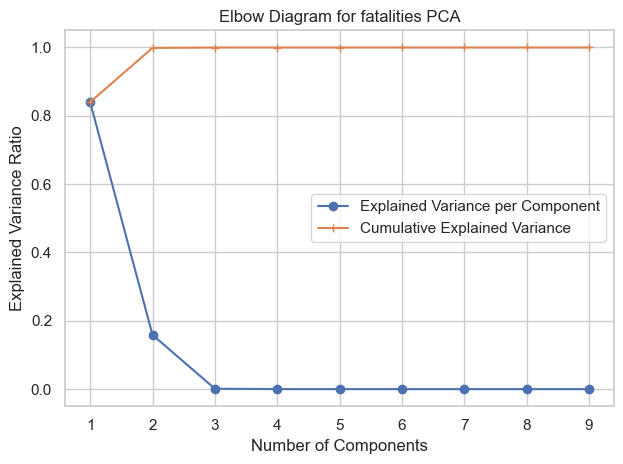

In [65]:
explained_variance=pca.explained_variance_ratio_
cumulative_explained_variance=np.cumsum(pca.explained_variance_ratio_)

plt.plot(components_range, explained_variance,marker='o', label='Explained Variance per Component')

plt.plot(components_range, cumulative_explained_variance,marker='+', label='Cumulative Explained Variance')

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Diagram for fatalities PCA')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Searching correlaztion between components of PCA Analysis and the data set

In [66]:
print(explained_variance)
print(cumulative_explained_variance)

[8.40154912e-01 1.58618508e-01 1.06261982e-03 1.01767769e-04
 3.07056467e-05 1.89348345e-05 9.56923562e-06 2.79835146e-06
 1.83632963e-07]
[0.84015491 0.99877342 0.99983604 0.99993781 0.99996851 0.99998745
 0.99999702 0.99999982 1.        ]


In [67]:
search_for_correlation = mydata[['citizenship_cat', 'event_location_cat',
    'event_location_district_cat', 'event_location_region_cat',
    'gender_cat', 'place_of_residence_cat',
    'place_of_residence_district_cat', 'type_of_injury_cat',
    'killed_by_cat']]

Using a normal distribution to add values in the explained_variance variable to see if there is correlation with the dataset

In [68]:
num_missing_values = len(search_for_correlation) - len(explained_variance)

missing_values = np.random.normal(loc=0, scale=1, size=num_missing_values)

In [69]:
a = missing_values.tolist()
b = explained_variance.tolist()
c = a + b

In [70]:
search_for_correlation['expl_variance'] = c

In [71]:
search_for_correlation_corr = search_for_correlation.corr()

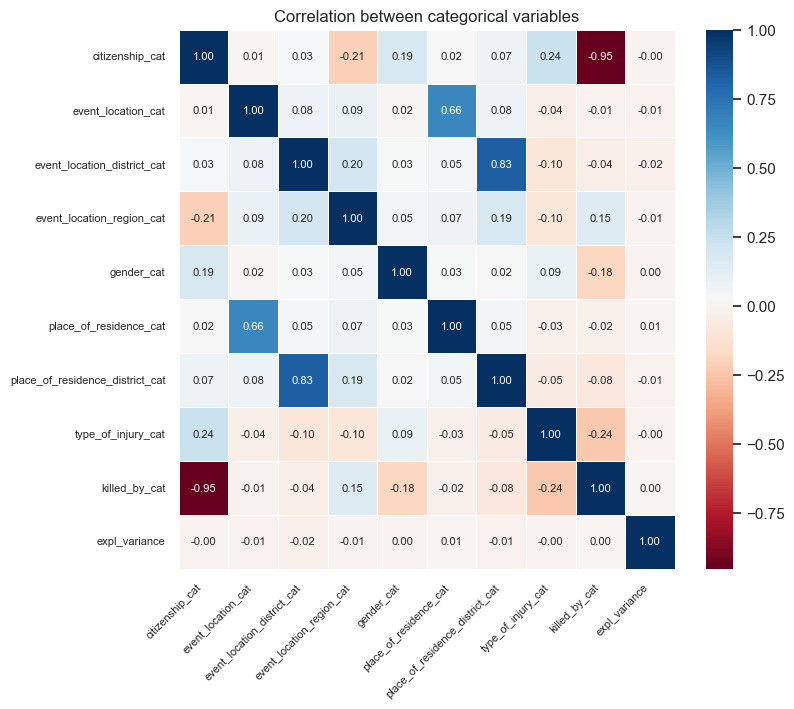

In [72]:
plt.figure(figsize = (8,7))
sns.set(style="whitegrid")
set_color = sns.color_palette("RdBu", as_cmap=True)
heatmap = sns.heatmap(search_for_correlation_corr, annot=True, fmt=".2f", linewidths=.5, annot_kws={"size": 8}, cmap=set_color)
plt.title("Correlation between categorical variables")
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=8)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=8)
plt.xticks(rotation=45, ha="right")
plt.show()

as we can see, there isn't correlation between them

### find best silhouette coefficiente using var (not working really well, very usefull)

In [73]:
target_variance_ratio = 0.84015491
num_components_to_keep = np.argmax(explained_variance >= target_variance_ratio) + 1
print(num_components_to_keep)

1


### find best silhouette coefficiente using loops (this is working really good)

this loop is based on choosing the maximum number of clusters you want by calculating for each individual operation the silhouette index, reporting the best coefficient at the end.

In [74]:
# Set the maximum number of clusters you wish to explore.
max_clusters = 10

# Initialize variables to keep track of the best results:
best_num_clusters = 2  # Start with a reasonable value
best_silhouette_score = -1  # nitialize with an impossible value

# find the value using loop
for num_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=num_clusters, random_state=20, n_init=10) # the random state number is arbitrarial but for different tests it has to be the same (centroids locations)
    kmeans_labels = kmeans.fit_predict(mydata)
    silhouette_avg = silhouette_score(mydata, kmeans_labels)
    
    # Update if the loop find a better solution
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_num_clusters = num_clusters

print(f"The maximum number of clusters with the best silhouette coefficient is: {best_num_clusters}")
print(f"Associated silhouette coeficient: {best_silhouette_score}")

### with max_clusters = 1000, the coefficient is equal to 0.7939302027453841 and the max numnber is 1000
### with max_clusters = 100, the coefficient is equal to 0.7148252056599078 and the max numnber is 100
### with max_cluserts = 10, the coefficent is equal to 0.5831316118613485 and the max number is 2

The maximum number of clusters with the best silhouette coefficient is: 2
Associated silhouette coeficient: 0.5831316118613485


## K-means Clustering

In [75]:
pca = PCA(n_components=2)
pca.fit(mydata)
pca_data=pca.fit_transform(mydata)
pca_data

array([[ 124.43310401,  -11.018131  ],
       [ 124.43310401,  -11.018131  ],
       [ 255.72583534,  184.37188485],
       ...,
       [ -44.51133546, -105.10077393],
       [-195.29329651,    9.08485395],
       [-154.72084194, -167.75956939]])

using only two clusters is in fact a very reductive choice since it is not possible to put all the variables into two macro groups. This choice was made for theoretical purposes only.

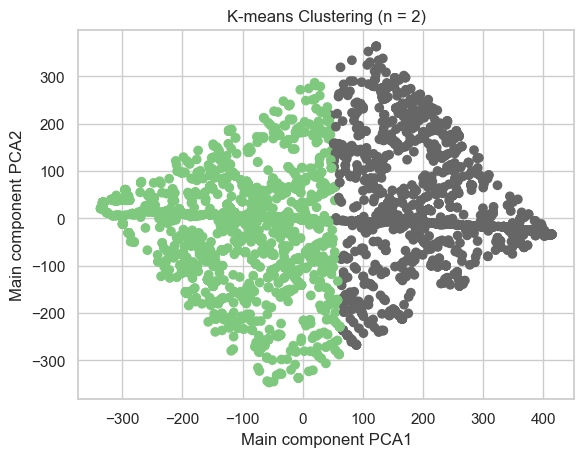

In [76]:
from sklearn.cluster import KMeans

kmeans_2 = KMeans(n_clusters=2, random_state=20, n_init=10)
kmeans_2.fit(mydata)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_2.labels_, cmap='Accent')
plt.xlabel('Main component PCA1')
plt.ylabel('Main component PCA2')
plt.title('K-means Clustering (n = 2)')
plt.show()

using a high value such as 100 or 1000 as the number of clusters, as we can observe, gives a higher silhouette coefficient as the number of clusters increases.

In [77]:
from sklearn.metrics import silhouette_score
print("evaluation for 2 clusters on data:", silhouette_score(mydata, kmeans_2.labels_))

evaluation for 2 clusters on data: 0.5831316118613485


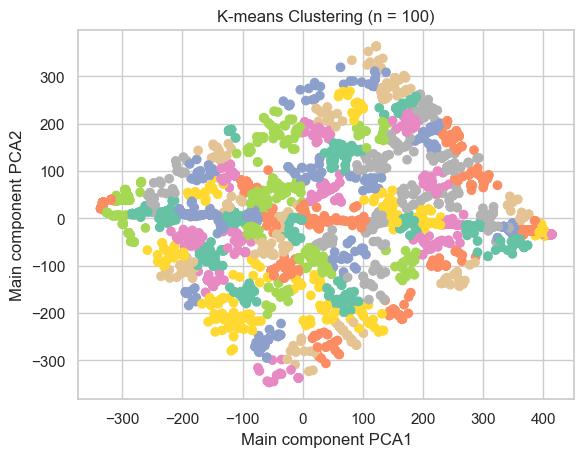

In [78]:
from sklearn.cluster import KMeans

kmeans_100 = KMeans(n_clusters=100, random_state=20, n_init=10)
kmeans_100.fit(mydata)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_100.labels_, cmap='Set2')
plt.xlabel('Main component PCA1')
plt.ylabel('Main component PCA2')
plt.title('K-means Clustering (n = 100)')
plt.show()

In [79]:
from sklearn.metrics import silhouette_score
print("evaluation for 100 clusters on data:", silhouette_score(mydata, kmeans_100.labels_))

evaluation for 100 clusters on data: 0.711101532770604


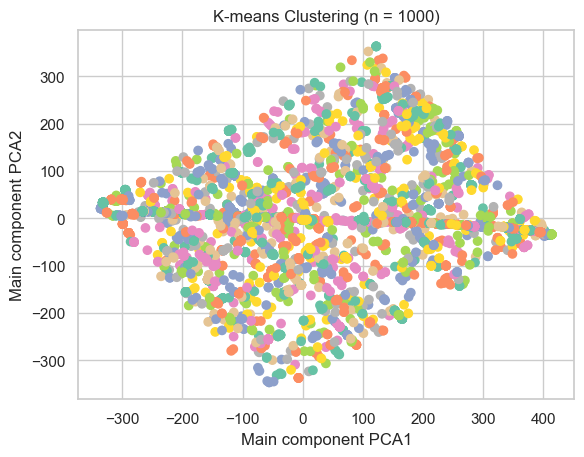

In [80]:
kmeans_1000 = KMeans(n_clusters=1000, random_state=20, n_init=10)
kmeans_1000.fit(mydata)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_1000.labels_, cmap='Set2')
plt.xlabel('Main component PCA1')
plt.ylabel('Main component PCA2')
plt.title('K-means Clustering (n = 1000)')
plt.show()

In [81]:
from sklearn.metrics import silhouette_score
print("evaluation for 1000 clusters on data:", silhouette_score(mydata, kmeans_1000.labels_))

evaluation for 1000 clusters on data: 0.7939302027453841


In [82]:
pca = PCA(n_components=9)
pca.fit(mydata)
pca_data9 = pca.fit_transform(mydata)
pca_data9

array([[ 1.24433104e+02, -1.10181310e+01,  1.31338756e+01, ...,
        -3.80656320e-01, -3.64652645e-02, -3.32248181e-02],
       [ 1.24433104e+02, -1.10181310e+01,  1.31338756e+01, ...,
        -3.80656320e-01, -3.64652645e-02, -3.32248181e-02],
       [ 2.55725835e+02,  1.84371885e+02, -5.14217929e-01, ...,
        -5.74294319e-01, -1.51180529e-02, -3.58422102e-02],
       ...,
       [-4.45113355e+01, -1.05100774e+02,  3.26937274e+00, ...,
         1.50884003e+00, -3.42446271e-01,  3.76433690e-04],
       [-1.95293297e+02,  9.08485395e+00,  1.11825054e+01, ...,
        -9.17297870e-01,  2.70834287e-02,  8.52409512e-01],
       [-1.54720842e+02, -1.67759569e+02,  4.28109404e+00, ...,
         1.40810947e+00, -3.18041004e-01,  2.73216859e-04]])

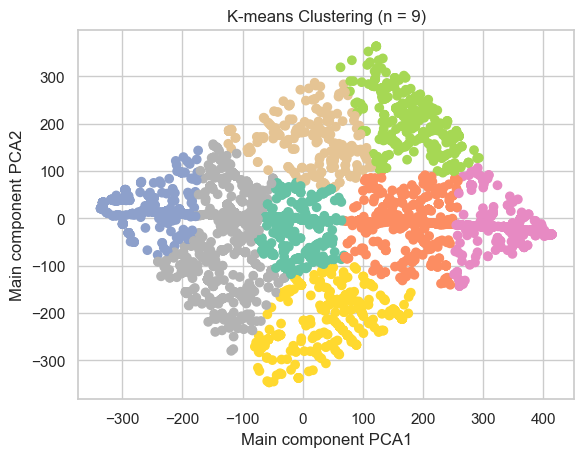

In [83]:
from sklearn.cluster import KMeans

kmeans_9 = KMeans(n_clusters=9, random_state=20, n_init=10)
kmeans_9.fit(mydata)
plt.scatter(pca_data9[:, 0], pca_data9[:, 1], c=kmeans_9.labels_, cmap='Set2')
plt.xlabel('Main component PCA1')
plt.ylabel('Main component PCA2')
plt.title('K-means Clustering (n = 9)')
plt.show()

In [84]:
from sklearn.metrics import silhouette_score
print("evaluation for 9 clusters on data:", silhouette_score(mydata, kmeans_9.labels_))

evaluation for 9 clusters on data: 0.5769198648257527
